### What is gradient boosting?

If you're inside the world of machine learning, it's for sure you have heard about gradient boosting algorithms such as xgboost or lightgbm. Indeed, gradient boosting represents the state-of-start for a lot of machine learning task, but how does it work? We'll try to answer this question specifically for the case of gradient boosting for trees which is the most popular case up today

 For me, understanding gradient boosting is all about undestarding its link to gradient descent. Remember gradient descent is the algorithm to minimize a loss function $L(\theta)$ by sustracting the gradient to the parameters

$$
\theta = \theta - \frac{\partial L(\theta)}{\partial \theta}
$$

 At first glance it doesn't make much sense; trees are based on a split-gain function (Gini, entropy), not a loss function. Moreover, what would be $\theta$?
 
 Recall $\theta = (\theta_1,\ldots,\theta_n)$ are the learned parameters we use for making predictions, which are the paramters of the loss functio. In gradient boosting, we consider the loss function as a function of the predictions instead, so we want to find $\min_{p}L(y,p)$ and the way to achieve that is analogous to gradient descent, i.e, updating the predictions on the opposite direction of the gradients. But how can you update the predicitions? I mean, once the tree is built it has a fixed structure. 
 
 Here comes the idea of additive modeling, in which you add (sequentially in this case) the predictions of several models in order to get a better performance. The first tree makes predictions on the original target, then, with the second tree, we try to minimize the loss function adding something which is not exactly minus the gradient loss, as in gradient descent, but instead we add *predictions on the gradients loss*, i.e, we fit a tree over with target the gradient loss. So, if $X,y$ represents the original data,$f$ the predict function and
$p = f(X,y)$ 

$$
p = p-f\left(X,\dfrac{\partial L(y,p)}{\partial p}\right)
$$ 

This equation would be the *gradient descent* version of trees. Maybe this is nothing new for you, but I hope it gives you a better or new way of seeing gradient boosting.

Now let's get our hands on some data and see a woking example

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import f1_score,roc_auc_score
import matplotlib.pyplot as plt

seed = 1301

We will work with a modified version of our familiar titanic dataset. This is a ready-to-train version: doesn't not contains missings and categorical data has been encoded.
(shout out to the person who made public this data)

In [2]:
file = "train_and_test2.csv" #data is in the repo
data = pd.read_csv(file)

data.head()

,Passengerid,Age,Fare,Sex,sibsp,zero,zero.1,zero.2,zero.3,zero.4,...,zero.12,zero.13,zero.14,Pclass,zero.15,zero.16,Embarked,zero.17,zero.18,2urvived
0,1,22.0,7.2500,0,1,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,0
1,2,38.0,71.2833,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0.0,0,0,1
2,3,26.0,7.9250,1,0,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,1
3,4,35.0,53.1000,1,1,0,0,0,0,0,...,0,0,0,1,0,0,2.0,0,0,1
4,5,35.0,8.0500,0,0,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,0


In [3]:
###to get train and test
def split_data(data,target,drop,test_size=0.2,seed=seed):
    
    return train_test_split(data.dropna().drop(target+drop,axis=1),
                            data.dropna()[target],
                            test_size=test_size,
                            random_state = seed)

In [4]:
drop,target  = ['Passengerid'],['2urvived']

#split the data
X_train,X_test,y_train,y_test = split_data(data,target,drop=drop)

Let's fit a base learner for the data.

In [5]:
tcl = DecisionTreeClassifier(max_depth=3,random_state=seed)
tcl.fit(X_train,y_train)
y_pred = tcl.predict(X_test)
y_prob = tcl.predict_proba(X_test)[:,1]
print(f"f1 score: {f1_score(y_test,y_pred):.2f}")
print(f"AUC score: {roc_auc_score(y_test,y_prob):.2f}")

f1 score: 0.63
AUC score: 0.86


Now we will construct a gradient booster class implementing the previous algorithm. Let's code it first and then talk a little bit about the details

In [6]:
class gradient_booster():
    def __init__(self,loss,gradient_loss,max_depth,nu):
        self.max_depth = max_depth #max depth of all learners
        self.nu = nu #learning rate
        self.loss = loss #loss function to be optimized
        self.gradient_loss = gradient_loss #gradient of the loss function
        self.learners = [] #list with all the learners
        self.loss_history = [] #loss through the process
    
    def fit(self,X,y,epochs):
        base_learner = DecisionTreeClassifier(max_depth=self.max_depth,random_state=seed)
        base_learner.fit(X,y)
        initial_probs = base_learner.predict_proba(X)[:,1]
        
        probs = initial_probs
        preds = initial_probs
        loss_history = [] 
        self.learners += [base_learner]
        target = y
        
        for _ in range(epochs):
            target = -gradient_loss(y,probs)
            rt = DecisionTreeRegressor(max_depth=self.max_depth,random_state=seed) #regressor tree
            rt.fit(X,target)
            self.learners.append(rt)
            preds += self.nu*rt.predict(X) #these are not probabilities!!!
            probs = 1 / (1 + np.exp(-preds)) #these are probabilities
            self.loss_history.append(self.loss(y,probs))
            
        return self
    
    def predict_proba(self,X):
        try:
            preds  = self.learners[0].predict_proba(X)[:,1]
            
            for m in self.learners[1:]:
                preds += self.nu*m.predict(X)

            return 1 / (1 + np.exp(-preds))
        
        except NotFittedError:
            print("Model not fitted yet")

I intenionally picked a classification problem over a regression because has some additional technical details worth understanding.

1. Note that the base learner is a classifier tree but the next learners are regressors due to the gradients being a continuous target.
2. The outputs of the regressor trees aren't probabilities and therefore the cumulative predictions `preds` neither are. That's why we pass them to the sigmoid function.
3. Finally, and this stand for the general case, we added a shrinkage parameter `nu` because of the same reasons we add it to gradient descent: the gradients can become crazy and overshoot the minimum.

Next we define the loss which is the classic binary deviance

In [7]:
def loss(y,p):
    return -2.0 * np.mean(y * np.log(p/(1-p)) - np.logaddexp(0.0, np.log(p/(1-p)))) 

In [8]:
def gradient_loss(y,p):
    return (p-y)/(p*(1-p))

Let's implement the booster and see how it performs

In [9]:
booster = gradient_booster(loss=loss,gradient_loss=gradient_loss,max_depth=3,nu=0.01)
X, y, epochs = X_train.values, y_train.values.ravel(), 50
booster.fit(X,y,epochs)
y_prob = booster.predict_proba(X_test)
y_pred = 1*(y_prob>0.5)
print(f"f1 score: {f1_score(y_test,y_pred):.2f}")
print(f"AUC score: {roc_auc_score(y_test,y_prob):.2f}")

f1 score: 0.71
AUC score: 0.88


Nice! We got decent increment in auc and a good amount of f1. To finish this notebook we'll plot the classic loss vs epochs plot to verify that the loss is decresing with every addition of a new tree.

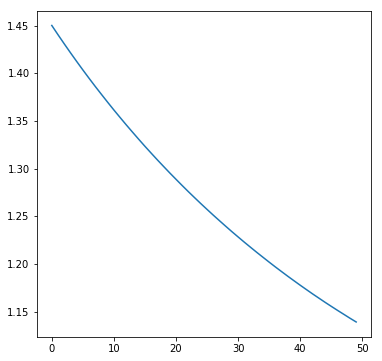

In [10]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
plt.plot(range(epochs),booster.loss_history)
plt.show()

### References
1. https://explained.ai/gradient-boosting/
2. https://web.stanford.edu/~hastie/Papers/ESLII.pdf